In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

churn = 3

Loading datasets

In [2]:
df_train = pd.read_feather(f"../../../data/processed/Churn_{churn}_train_set.feather")

In [3]:
df_opt = pd.read_feather(f"../../../data/processed/Churn_{churn}_optimization_set.feather")

split X, y 

In [4]:
X_train = df_train.drop([f"BAJA_{churn}m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window","index"], axis=1)
y_train = df_train[f"BAJA_{churn}m"]
del df_train

In [5]:
X_opt = df_opt.drop([f"BAJA_{churn}m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window","index"], axis=1)
y_opt = df_opt[f"BAJA_{churn}m"]
del df_opt

Dummifying

In [6]:
X_train = pd.get_dummies(X_train)
X_train = X_train.fillna(-999)

In [7]:
cols = list(X_train.columns)

In [8]:
X_opt = pd.get_dummies(X_opt)
X_opt = X_opt.fillna(-999)
for col in [col for col in X_train.columns if col not in X_opt.columns]:
    X_opt[col] = -999

In [9]:
X_opt = X_opt.drop([col for col in X_opt.columns if col not in X_train.columns], axis=1)

In [10]:
for y in [y_train, y_opt]:
    print(y.value_counts(normalize=True))

False    0.979157
True     0.020843
Name: BAJA_3m, dtype: float64
False    0.978769
True     0.021231
Name: BAJA_3m, dtype: float64


In [11]:
len(X_opt.columns) 

460

In [12]:
len(X_train.columns)

460

## Training

In [13]:
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.metrics import f1_score, roc_auc_score 
from numpy.random import RandomState
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm_notebook as tqdm

In [14]:
from sklearn.utils.class_weight import compute_class_weight 

In [15]:
compute_class_weight("balanced", y_train.unique(), y_train)

array([ 0.51064318, 23.98922618])

In [16]:
space = {
    "algo": hp.choice("algo", [RandomForestClassifier, ExtraTreesClassifier]),
    "params": {
        "n_estimators": hp.choice("n_estimators", [40, 80, 100]),  # 100, 400
        "min_samples_leaf": hp.choice("min_samples_leaf", [5, 20, 35, 55]), # , 65
        "max_depth": hp.choice("max_depth", [5, 10, 15]), # 10,
        "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
        "class_weight": hp.choice("class_weight", [{0:1, 1:20}, {0:1, 1:30},  {0:1, 1:40}]) ,
    }
}

In [17]:
evals = 40
pbar = tqdm(total=evals)

def __optimizerFunc(args):
    pbar.update(0.5)
    args["params"]["verbose"] = 1
    args["params"]["n_jobs"] = -1
    args["params"]["random_state"] = 42
    model = args["algo"](**args["params"])
    print(f"Trying: {model}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_opt) 
    pbar.update(0.5)
    # greater is better
    return {"loss": -f1_score(y_opt, y_pred), "status": STATUS_OK,}
          
trials = Trials()
__bestClassifier = fmin(fn=__optimizerFunc,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=evals,
                        trials=trials,
                        rstate=RandomState(42)
                        )
pbar.close()

print("{}\n".format(trials.results))

Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 20.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=10, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 37.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 25.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.6s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 12.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 50.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=15, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 32.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=10, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 26.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 46.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  8.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   20.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=10, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   45.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 42.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 20.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 20.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 21.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 20.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 21.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished



[{'loss': -0.4298483981693364, 'status': 'ok'}, {'loss': -0.5453024034215053, 'status': 'ok'}, {'loss': -0.6536837660966857, 'status': 'ok'}, {'loss': -0.26995866869697627, 'status': 'ok'}, {'loss': -0.530528651277894, 'status': 'ok'}, {'loss': -0.5884095360947877, 'status': 'ok'}, {'loss': -0.595049408081401, 'status': 'ok'}, {'loss': -0.7617759193211167, 'status': 'ok'}, {'loss': -0.7626859977107975, 'status': 'ok'}, {'loss': -0.2077661556096862, 'status': 'ok'}, {'loss': -0.5367535141910647, 'status': 'ok'}, {'loss': -0.17669411019632678, 'status': 'ok'}, {'loss': -0.76275980814168, 'status': 'ok'}, {'loss': -0.5569331623200798, 'status': 'ok'}, {'loss': -0.7539489292626583, 'status': 'ok'}, {'loss': -0.7282563462338743, 'status': 'ok'}, {'loss': -0.5476454170912153, 'status': 'ok'}, {'loss': -0.6004436300511139, 'status': 'ok'}, {'loss': -0.16219247213850144, 'status': 'ok'}, {'loss': -0.19885595423816954, 'status': 'ok'}, {'loss': -0.7494813604073678, 'status': 'ok'}, {'loss': -0

In [18]:
print("Best Config:")
opt_config = space_eval(space, __bestClassifier)
print(opt_config)

Best Config:
{'algo': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'params': {'class_weight': {0: 1, 1: 30}, 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 80}}


In [19]:
rf = opt_config['algo'](**opt_config['params'])

In [20]:
rf

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [21]:
rf = RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)

In [22]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80building tree 7 of 80building tree 8 of 80







building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.2min


building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tr

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 32.8min finished


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)

---

### Feature importance

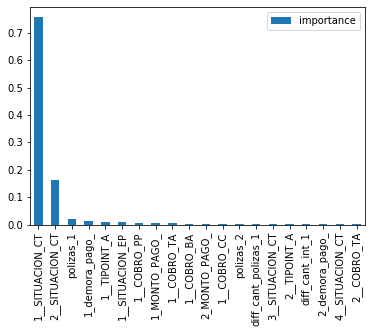

In [23]:
pd.DataFrame(rf.feature_importances_,index=X_train.columns, columns=['importance']
                                   ).sort_values('importance', ascending=False).iloc[0:20].plot.bar()

**METRICS**

In [24]:
df_val = pd.read_feather(f"../../../data/processed/Churn_{churn}_validation_set.feather")

In [25]:
X_val = df_val.drop([f"BAJA_{churn}m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window","index"], axis=1)
y_val = df_val[f"BAJA_{churn}m"]
del df_val

In [26]:
X_val = pd.get_dummies(X_val)
X_val = X_val.fillna(-999)
for col in [col for col in X_train.columns if col not in X_val.columns]:
    X_val[col] = -999

In [27]:
X_val = X_val.drop([col for col in X_val.columns if col not in X_train.columns], axis=1)

In [28]:
len(X_val.columns)

460

In [29]:
predictions = rf.predict(X_val)
pd.Series(predictions).value_counts()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


False    285238
True       9959
dtype: int64

In [30]:
import seaborn as sns

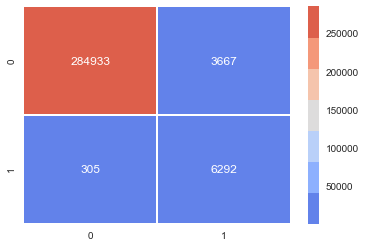

In [31]:
cmap = sns.color_palette("coolwarm", 7)
sns.set(font_scale=1)
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d", linewidths=.5, cmap=cmap) 

In [32]:
print(f'ROC AUC: {roc_auc_score(y_val, predictions)} ') 

ROC AUC: 0.9705303480098841 


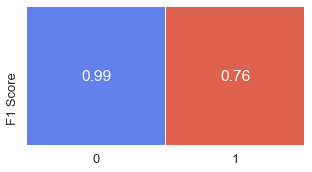

In [33]:
data = pd.DataFrame(columns=range(2), data=[f1_score(y_val, predictions, average=None)])
data.index = ["F1 Score"]
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5))
sns.set(font_scale=1.3)
cmap = sns.color_palette("coolwarm_r", 7)
sns.heatmap(data, annot=True, linewidths=.5, cmap=cmap, square=True, cbar=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


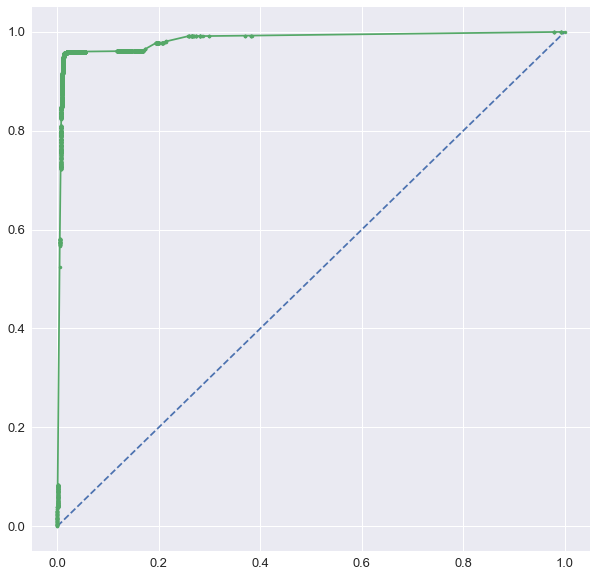

In [34]:
from sklearn.metrics import roc_curve

probs = rf.predict_proba(X_val)
probs = probs[:, 1]
fig=plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(y_val, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Dumping model

In [35]:
import pickle

In [36]:
with open(f'../../../src/models/Churn{churn}-Hyperotimization-f1-Dummies.md', 'wb') as file:
    pickle.dump(rf, file, pickle.HIGHEST_PROTOCOL)